In [698]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
from matplotlib.animation import FuncAnimation
import math
import random
from tqdm import tqdm

In [699]:
class MBSimulation:

    def __init__(self, x, v, r, m, R, ballistic):
        '''
        x: initial position of particles
        
        v: initial velocity of particles

        r: radius of particles

        m: mass of particles

        nsteps: number of steps taken in the simulation

        R: radius of the circular tube
        '''
        
        self.x = np.asarray(x, dtype=float)
        self.v = np.asarray(v, dtype=float)
        self.exposure_time = np.zeros(self.x.shape[0])
        self.in_beam = np.zeros(self.x.shape[0])
        self.n = self.x.shape[0]
        self.r = r  # radius of particles
        self.m = m  # mass of particles
        self.nsteps = 0
        self.R = R  # radius of the circular tube
        self.ballistic = ballistic
        self.num_collisions = 0


        for i in range(self.n):
            if np.linalg.norm(self.x[i]) <= self.R:
                self.in_beam[i] = 1
    
        

    def advance(self, dt):
        # Propagate the particles through time
        self.nsteps += 1
        self.x += self.v * dt

        # Keep track of exposure
        for i in range(self.n):
            if np.linalg.norm(self.x[i]) <= self.R:
                self.exposure_time[i] += 1
                self.in_beam[i] = 1
            else:
                self.in_beam[i] = 0
                

        # Get the indices of colliding particles
        dist = squareform(pdist(self.x))
        i_coll, j_coll = np.where(dist < 2 * self.r)
        k = np.where(i_coll < j_coll)
        i_coll, j_coll = i_coll[k], j_coll[k]
        self.num_collisions += len(i_coll)

        if self.ballistic == False:
            # Update the velocities of colliding particles
            for i, j in zip(i_coll, i_coll):
                pos_i, vel_i = self.x[i], self.v[i]
                pos_j, vel_j =  self.x[j], self.v[j]
            
                rel_pos, rel_vel = pos_i - pos_j, vel_i - vel_j
                r_rel = np.dot(rel_pos, rel_pos)
                v_rel = np.dot(rel_vel, rel_pos)
                v_rel = 2 * rel_pos * v_rel / r_rel - rel_vel
                v_cm = (vel_i + vel_j) / 2
                self.v[i] = v_cm - v_rel/2
                self.v[j] = v_cm + v_rel/2

        # # Bounce particles off circular tube
        # for i in range(self.n):
        #     dist_from_origin = np.linalg.norm(self.x[i])
        #     if dist_from_origin + self.r > self.R:
        #         normal = self.x[i] / dist_from_origin
        #         self.v[i] -= 2 * (self.v[i] @ normal) * normal



In [700]:
def MaxwellBoltzmann(v, m, T):
    # Maxwell-Boltzmann distribution
    return np.sqrt(m / (2 * np.pi * T)) ** 3 * 4 * np.pi * v ** 2 * np.exp(-m * v ** 2 / (2 * T))

k_Boltzmann = 1.38064852e-23 # Boltzmann constant

def get_mean_velocity(m, T):
    # Mean velocity of particles
    return np.sqrt(8 * k_Boltzmann * T / (np.pi * m))

In [701]:
def init_pos_vel(R, v_bar, n):

    # Generate n random positions within the beam profile.
    x_list_in = []
    y_list_in = []

    x_list_out = []
    y_list_out = []

    R_around = 2 * R
    for i in range(n):
        # random angle
        alpha = 2 * math.pi * random.random()
        # random radius
        rand_R = R_around * math.sqrt(random.random())
        # calculating coordinates
        x = rand_R * math.cos(alpha)
        y = rand_R * math.sin(alpha)

        if np.linalg.norm([x, y]) > R:
            x_list_out.append(x)
            y_list_out.append(y)

        else:
            x_list_in.append(x)
            y_list_in.append(y)

    pos_in = np.array([x_list_in, y_list_in]).T
    pos_out = np.array([x_list_out, y_list_out]).T




    # Initialize the particles velocities with random orientations and random
    # magnitudes  around the mean speed, sbar.
    theta_in = np.random.random(len(x_list_in)) * 2 * np.pi
    theta_out = np.random.random(len(x_list_out)) * 2 * np.pi
    s0_in = v_bar * np.random.random(len(x_list_in))
    s0_out = v_bar * np.random.random(len(x_list_out))

    vel_in = (s0_in * np.array((np.cos(theta_in), np.sin(theta_in)))).T
    vel_out = (s0_out * np.array((np.cos(theta_out), np.sin(theta_out)))).T

    return pos_in, vel_in, pos_out, vel_out


In [702]:
def get_ensemble_fraction_in_beam(sim_in, sim_out, Time, dt):
    
    avg_exposure_beam_in_list = []
    print("Simulating the particles inside the beam")
    for i in tqdm(range(int(Time / dt))):
        avg_exp_in = np.mean(sim_in.exposure_time[np.where(sim_in.in_beam == 1)])
        avg_exposure_beam_in_list.append(avg_exp_in)
        sim_in.advance(dt)
        
    # Get the fraction of atoms inside the circular tube
    dist_in = np.linalg.norm(sim_in.x, axis=1)
    sum_in = np.sum(dist_in < sim_in.R)

    avg_exposure_beam_out_list = []
    print("Simulating the particles outside the beam")
    for i in tqdm(range(int(Time / dt))):
        avg_exp_out = np.mean(sim_out.exposure_time[np.where(sim_out.in_beam == 1)])
        if math.isnan(avg_exp_out):
            avg_exp_out = 0
        avg_exposure_beam_out_list.append(avg_exp_out)
        sim_out.advance(dt)
    
    dist_out = np.linalg.norm(sim_out.x, axis=1)
    sum_out = np.sum(dist_out < sim_out.R)
    

    fraction_pumped_atoms = sum_in / (sum_in + sum_out)

    number_density_F1 = sum_in / (sum_in + sum_out) * 3/8
    
    return fraction_pumped_atoms, number_density_F1, avg_exposure_beam_in_list, avg_exposure_beam_out_list

### Init params and instantiate simulation

In [703]:
# Parameters

# Number of particles.
n = 1000

T = 300  # K
m = 1.44e-25  # kg Rb-87
v_bar = get_mean_velocity(m, T)
print(f"Mean velocity at T = {T} K: {np.round(v_bar)} m/s")

# Time evolution step
dt = 1e-9

# Time necessary for pumping
Time = 500e-9

# Radius of beam
R = 100e-6

# Radius of the particles
r = 20e-8

# Initialize the particles
pos_in, vel_in, pos_out, vel_out = init_pos_vel(R, v_bar, n)

# Initialize the simulation
sim_in = MBSimulation(pos_in, vel_in, r, m, R, True)
sim_out = MBSimulation(pos_out, vel_out, r, m, R, True)


Mean velocity at T = 300 K: 271.0 m/s


### Plot circle with particles

In [704]:
# # Plot positions in a circle
# plt.scatter(sim_in.x[:, 0], sim_in.x[:, 1])
# plt.scatter(sim_out.x[:, 0], sim_out.x[:, 1])
# circle = plt.Circle((0, 0), R, color='r', fill=False)
# plt.gca().add_patch(circle)
# plt.axis('equal')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Particle Positions')
# plt.show()


# # Advance

# print(sim_in.exposure_time[np.where(sim_in.in_beam == 1)])
# print(sim_out.exposure_time[np.where(sim_out.in_beam == 1)])
# sim_in.advance(dt)
# sim_out.advance(dt)

In [705]:
fraction_inside, number_density_F1, exposure_list_in, exposure_list_out = get_ensemble_fraction_in_beam(sim_in, sim_out, Time, dt)
print(f"Fraction of pumped atoms after time {Time} s at temp. {T} K inside the beam: {round(fraction_inside, 4)}")
print(f"Number density of F=1 atoms inside the beam: {round(number_density_F1, 4)}")

Simulating the particles inside the beam


  0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 499/499 [00:00<00:00, 986.95it/s] 


Simulating the particles outside the beam


  0%|          | 0/499 [00:00<?, ?it/s]/home/otps3141/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/otps3141/.local/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 499/499 [00:02<00:00, 192.33it/s]

Fraction of pumped atoms after time 5e-07 s at temp. 300 K inside the beam: 0.6292
Number density of F=1 atoms inside the beam: 0.2359


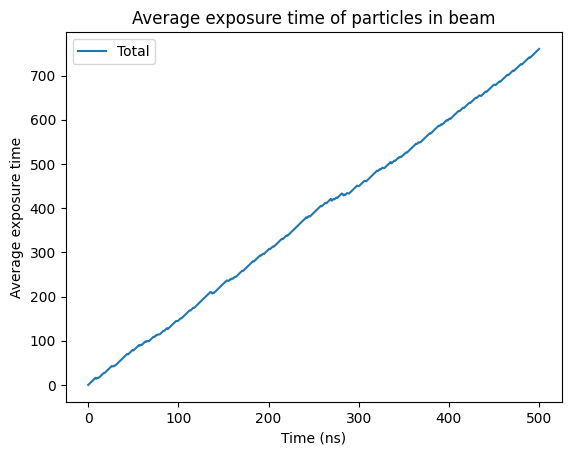

In [706]:
exp_time_array = np.linspace(0, Time, len(exposure_list_in))

avg_exp_total = np.array(exposure_list_in) + np.array(exposure_list_out)

plt.plot(exp_time_array*10e8, avg_exp_total, label='Total')
plt.xlabel('Time (ns)')
plt.ylabel('Average exposure time')
plt.legend()
plt.title('Average exposure time of particles in beam')
plt.show()


In [639]:
# Get average exposure time of atoms in beam after certain time
exposure_beam_in = sim_in.exposure_time[np.where(sim_in.in_beam == 1)]
exposure_beam_out = sim_out.exposure_time[np.where(sim_out.in_beam == 1)]
exposure_list_total = np.concatenate((exposure_beam_in, exposure_beam_out))
t_exp = round(np.mean(exposure_list_total), 1)
print(f"Average exposure time of atoms in the beam: {t_exp} ns")

# Number density F=2 atoms
avg_number_density_F2 = 5/8 + t_exp/30 * 0.25 * 1/np.exp(1) 
print(f"Number density of F=2 atoms: {round(avg_number_density_F2, 4)}")

Average exposure time of atoms in the beam: 404.8 ns
Number density of F=2 atoms: 1.866


In [ ]:
def get_lifetime(R, frac, r, ballistic):
    # Initialize the simulation
    pos, vel = init_pos_vel(R)
    sim = MBSimulation(pos, vel, r, m, R, ballistic)


    gamma_list = []
    simulation_time = 10000e-9

    # Simulate the particles for a given time.
    for i in range(int(simulation_time / dt)):


        
        dist_from_origin = np.linalg.norm(sim.x, axis=1)
        particles_outside = np.where(dist_from_origin > sim.R)
        N_outside = len(particles_outside[0])
        gamma = N_outside / sim.n

        if gamma > frac:
            break
        
        gamma_list.append(gamma)
        
        
        
        sim.advance(dt)

    # Define lifetime for specific R as the time where frac of the particles are outside the tube
    lifetime = i * dt
    num_collisions = sim.num_collisions

    return lifetime, gamma_list, num_collisions


In [ ]:
R_range = np.linspace(200e-6, 500e-6, 20)
lifetime_list = []
collision_list = []
gamma_list = []
frac = 1- 1/np.exp(1)
r = 2.5e-10

for R in tqdm(R_range):
    lifetime, gamma, num_collisions = get_lifetime(R, frac, r, True)
    lifetime_list.append(lifetime)
    collision_list.append(num_collisions)
    gamma_list.append(gamma)

# Take only non-zero lifetimes
lifetime_list = np.array(lifetime_list)
R_range = R_range[lifetime_list > 0]
lifetime_list = lifetime_list[lifetime_list > 0]

In [ ]:
# Fit linear function to lifetime vs R
m, b = np.polyfit(R_range, lifetime_list, 1)
print(f"Linear fit: y = {m:.2e}x + {b:.2e}")

# Plot linear fit

# Print lifetime for R = 400 um
print(f"Lifetime for R = 400 um: {lifetime_list[np.where(R_range == 400e-6)[0][0]]:.2e} s")

plt.plot(R_range, lifetime_list)
plt.plot(R_range, m * R_range + b)
plt.xlabel('R (m)')
plt.ylabel('Lifetime (s)')
plt.title('Lifetime vs R')
plt.show()


In [ ]:
np.mean(lifetime_list[np.where((R_range < 420e-6)) and np.where((R_range > 380e-6))[0]])

In [ ]:
np.where((R_range < 420e-6)) and np.where((R_range > 380e-6))